In [1]:
import os
from model import unet_model
from keras.utils import normalize
import glob
import numpy as np
import cv2
import matplotlib.pyplot as plt
from patchify import patchify
import tifffile as tiff
from PIL import Image
from sklearn.model_selection import train_test_split
import random
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from keras.metrics import MeanIoU
from tensorflow.keras.models import load_model
import csv
import pandas as pd

### **1. Initial setup**

#### **1.1 Prepare data**

In [20]:
directory = '../data/Sandstone/'
image_dir = 'data_for_3D_Unet/train_images_256_256_256.tif'
mask_dir = 'data_for_3D_Unet/train_masks_256_256_256.tif'

image_stack = tiff.imread(os.path.join(directory + 'original', image_dir))
mask_stack = tiff.imread(os.path.join(directory + 'original', mask_dir))

image_stack.shape, mask_stack.shape

((256, 256, 256), (256, 256, 256))

In [15]:
def extract_tiff_images(stack, name):
    for slice in range(stack.shape[0]):
        image = stack[slice]
        patches_img = patchify(image, (256, 256), step=256)
        for i in range(patches_img.shape[0]):
            for j in range(patches_img.shape[1]):
                single_patch_img = patches_img[i,j,:,:]
                tiff.imwrite(os.path.join(directory, f"{name}s/{name}_{slice:04d}.png"), single_patch_img)

extract_tiff_images(image_stack, name="image")
extract_tiff_images(mask_stack, name="mask")

#### **1.3 Configurations**

In [ ]:
# Read an sample to get correct configuration
path = "../data/Sandstone/images/image_0001.png"
img = cv2.imread(path, cv2.IMREAD_COLOR)
h, w, c = img.shape

In [ ]:
cf = {
    'n': 4,     # number of classes
    'h': h,     # input image height - actual size
    'w': w,     # input image width  - actual size
    'c': 1,     # number of channel
}

#### **1.2 Input pipeline**

In [74]:
image_directory = directory + 'images/'
mask_directory = directory + 'masks/'

def read_input(directory):
    ds = []
    files = os.listdir(directory)
    for i, file in enumerate(files):    
        if (file.split('.')[1] == 'png'):
            image = cv2.imread(directory + file, 0)
            image = Image.fromarray(image)
            ds.append(np.array(image))
    return ds


image_ds = np.array(read_input(image_directory))
mask_ds = np.array(read_input(mask_directory))

print(image_ds.shape, np.max(image_ds), np.min(image_ds))
print(mask_ds.shape, np.max(mask_ds), np.min(mask_ds))

(256, 256, 256) 255 0
(256, 256, 256) 3 0


In [ ]:
labelencoder = LabelEncoder()
n, h, w = mask_ds.shape

# normalize and expand dims
mask_ds_reshaped = mask_ds.reshape(-1,1)
mask_ds_reshaped_encoded = labelencoder.fit_transform(mask_ds_reshaped)
mask_ds_encoded_original_shape = mask_ds_reshaped_encoded.reshape(n, h, w)
mask_input = np.expand_dims(mask_ds_encoded_original_shape, axis=3)
image_ds_norm = normalize(np.expand_dims(image_ds, axis=3), axis=1)

# Train test split
X_train, X_val, y_train, y_val = train_test_split(image_ds_norm, mask_input, test_size = 0.1, random_state = 0)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = 0.2, random_state = 0)

# To categorical
print("Classes: ", np.unique(y_train)) 
y_train_cat = to_categorical(y_train, num_classes=cf['n'])
y_test_cat = to_categorical(y_test, num_classes=cf['n'])
y_val_cat = to_categorical(y_val, num_classes=cf['n'])

### **2. Model training**

#### **2.1 Model architecture**

In [142]:
model = unet_model(cf)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_96 (Conv2D)             (None, 256, 256, 16  160         ['input_8[0][0]']                
                                )                                                                 
                                                                                                  
 dropout_46 (Dropout)           (None, 256, 256, 16  0           ['conv2d_96[0][0]']              
                                )                                                           

#### **2.2 Model fitting**

In [100]:
history = model.fit(
    X_train, y_train_cat, 
    batch_size=16, 
    verbose=1, 
    epochs=20, 
    validation_data=(X_val, y_val_cat), 
    shuffle=False
)

Epoch 1/20
12/12 [==============================] - 3s 218ms/step - loss: 0.5274 - accuracy: 0.8245 - val_loss: 0.4754 - val_accuracy: 0.8267
Epoch 2/20
12/12 [==============================] - 3s 208ms/step - loss: 0.4825 - accuracy: 0.8248 - val_loss: 0.4409 - val_accuracy: 0.8298
Epoch 3/20
12/12 [==============================] - 2s 190ms/step - loss: 0.4314 - accuracy: 0.8522 - val_loss: 0.4519 - val_accuracy: 0.8817
Epoch 4/20
12/12 [==============================] - 2s 182ms/step - loss: 0.3689 - accuracy: 0.8888 - val_loss: 0.4275 - val_accuracy: 0.8947
Epoch 5/20
12/12 [==============================] - 2s 176ms/step - loss: 0.3178 - accuracy: 0.8969 - val_loss: 0.3732 - val_accuracy: 0.9036
Epoch 6/20
12/12 [==============================] - 2s 175ms/step - loss: 0.2957 - accuracy: 0.9001 - val_loss: 0.3317 - val_accuracy: 0.9095
Epoch 7/20
12/12 [==============================] - 2s 173ms/step - loss: 0.2740 - accuracy: 0.9021 - val_loss: 0.3008 - val_accuracy: 0.9121
Epoch 

#### **2.3 Save models and results**

In [ ]:
# Extracting the training history
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Define the file name
file_name = f'unet_sandstone_{epochs}.csv'

# Writing the data into a CSV file
with open(file_name, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Epoch', 'Train Accuracy', 'Val Accuracy', 'Train Loss', 'Val Loss'])
    for epoch in range(len(train_accuracy)):
        writer.writerow([epoch+1, train_accuracy[epoch], val_accuracy[epoch], train_loss[epoch], val_loss[epoch]])

print(f"Training history has been saved to {file_name}")

In [101]:
model.save('../models/unet_sandstone_20.hdf5')   # architectyre_dataset_epochs
_, acc = model.evaluate(X_test, y_test_cat)
print("Accuracy is = ", (acc * 100.0), "%")

2/2 [==============================] - 5s 2s/step - loss: 0.1598 - accuracy: 0.9464
Accuracy is =  94.63816285133362 %


### **3. Visualization**

#### **3.1 Training graph**

In [ ]:
def read_output(option_csv=False):
    # Read from saved .csv file from results directory
    if option_csv==True:
        df = pd.read_csv('../results/unet_sandstone_20_ce_inp.csv')
        return df['Train Loss'].tolist(), df['Val Loss'].tolist(), df['Train Accuracy'].tolist(), df['Val Accuracy'].tolist()
    
    # Use from tensorflow history
    else:
        return history.history['loss'], history.history['val_loss'], history.history['accuracy'], history.history['val_accuracy']

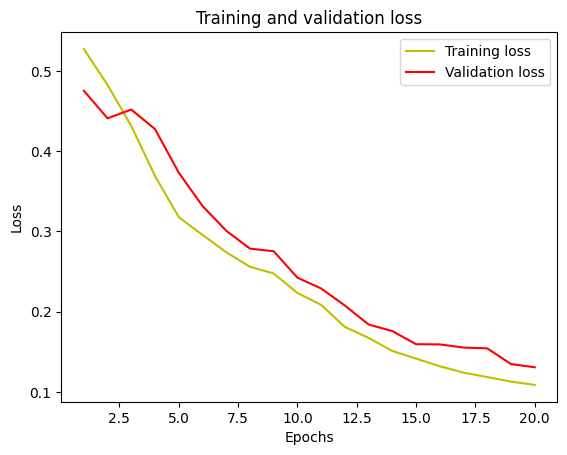

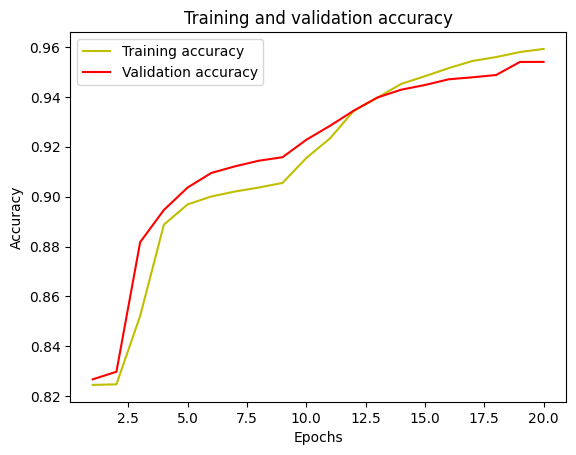

In [107]:
def visualize(epochs, scores_1, scores_2, legend_1, legend_2, x_label, y_label, title):
    plt.plot(epochs, scores_1, 'y', label=legend_1)
    plt.plot(epochs, scores_2, 'r', label=legend_2)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend()
    plt.show()
    

loss, val_loss, acc, val_acc = read_output(option_csv=False)
epochs = range(1, len(loss) + 1)
visualize(epochs, loss, val_loss, 'Training loss', 'Validation loss', 'Epochs', 'Loss', 'Training and validation loss')
visualize(epochs, acc, val_acc, 'Training accuracy', 'Validation accuracy', 'Epochs', 'Accuracy', 'Training and validation accuracy')

#### **3.2 Other metrics: DSC & IOU**

In [127]:
def prediction(batch_of_images):
    y_pred = model.predict(batch_of_images)
    return np.argmax(y_pred, axis=3)

def compute_IOU():
    IOU_keras = MeanIoU(num_classes=cf['n'])  
    IOU_keras.update_state(y_test[:,:,:,0], prediction(X_test))
    print("Mean IoU =", IOU_keras.result().numpy())
    
    values = np.array(IOU_keras.get_weights()).reshape(cf['n'], cf['n'])
    print(values)
    class1_IoU = values[0,0] / (values[0,0] + values[0,1] + values[0,2] + values[0,3] + values[1,0] + values[2,0] + values[3,0])
    class2_IoU = values[1,1] / (values[1,1] + values[1,0] + values[1,2] + values[1,3] + values[0,1]+ values[2,1]+ values[3,1])
    class3_IoU = values[2,2] / (values[2,2] + values[2,0] + values[2,1] + values[2,3] + values[0,2]+ values[1,2]+ values[3,2])
    class4_IoU = values[3,3] / (values[3,3] + values[3,0] + values[3,1] + values[3,2] + values[0,3]+ values[1,3]+ values[2,3])

    print("IoU for class 1 is: ", class1_IoU)
    print("IoU for class 2 is: ", class2_IoU)
    print("IoU for class 3 is: ", class3_IoU)
    print("IoU for class 4 is: ", class4_IoU)
    
compute_IOU()

2/2 [==============================] - 0s 315ms/step
Mean IoU = 0.6756067
[[2.625670e+05 6.459000e+03 4.792000e+03 0.000000e+00]
 [1.152100e+04 1.362730e+05 3.713000e+04 0.000000e+00]
 [1.187200e+04 3.693200e+04 2.433802e+06 4.810000e+02]
 [2.000000e+00 1.800000e+01 5.243400e+04 2.037300e+04]]
IoU for class1 is:  0.8834304
IoU for class2 is:  0.59681696
IoU for class3 is:  0.94426996
IoU for class4 is:  0.27790964


### **4. Run inference**

1/1 [==============================] - 0s 26ms/step


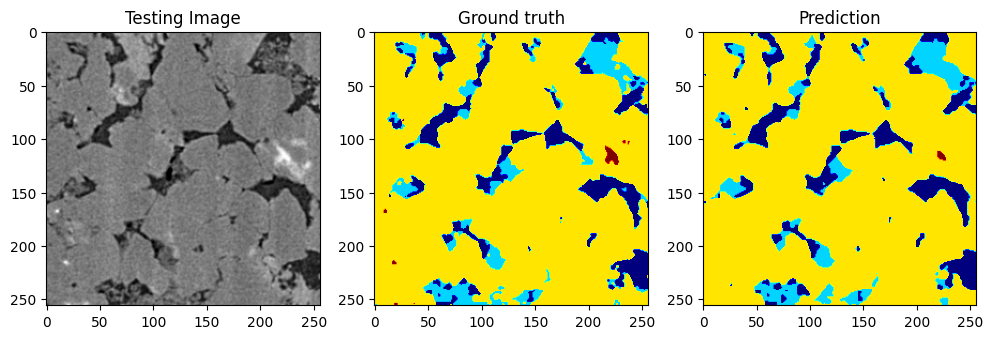

1/1 [==============================] - 0s 23ms/step


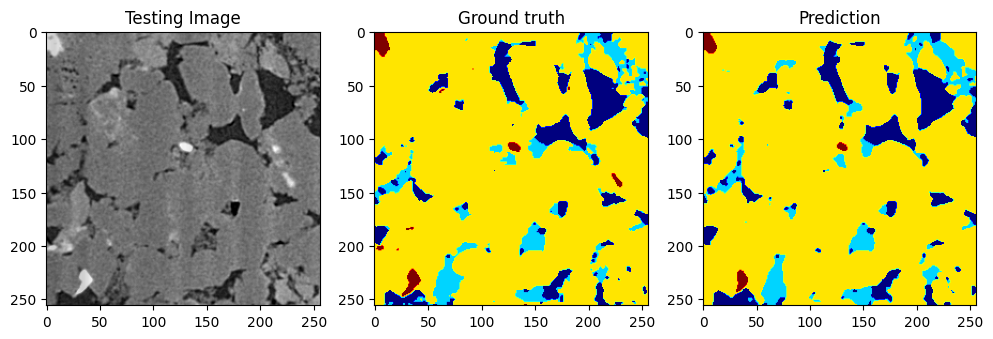

1/1 [==============================] - 0s 23ms/step


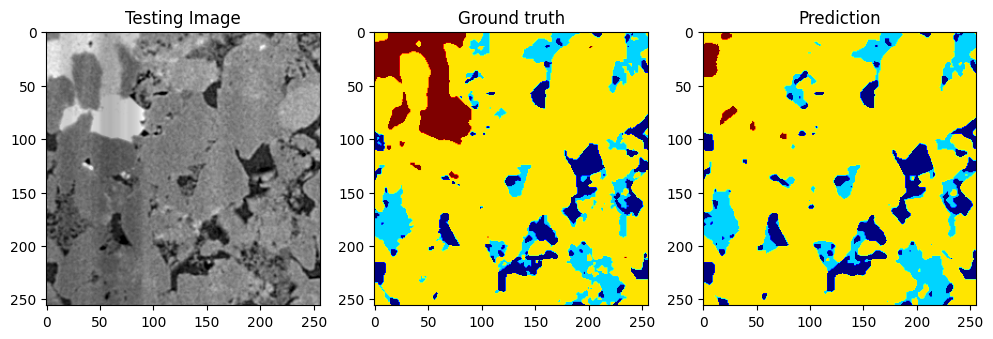

1/1 [==============================] - 0s 26ms/step


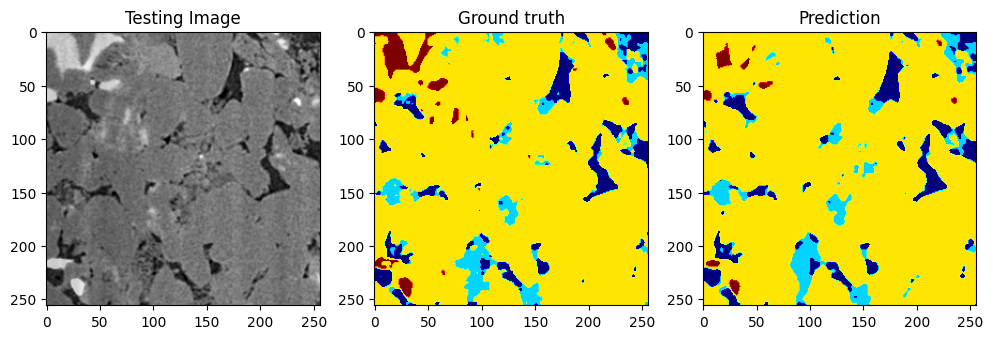

1/1 [==============================] - 0s 25ms/step


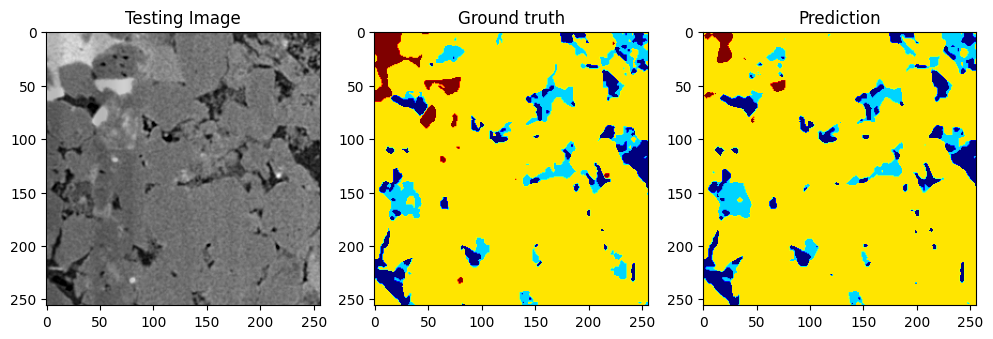

1/1 [==============================] - 0s 25ms/step


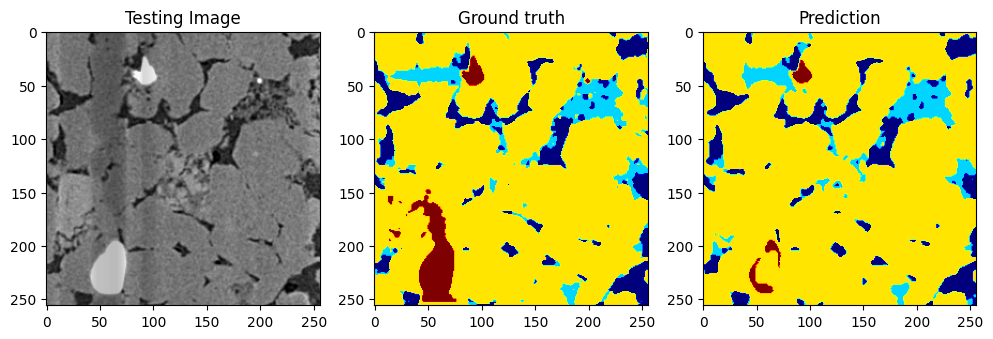

1/1 [==============================] - 0s 26ms/step


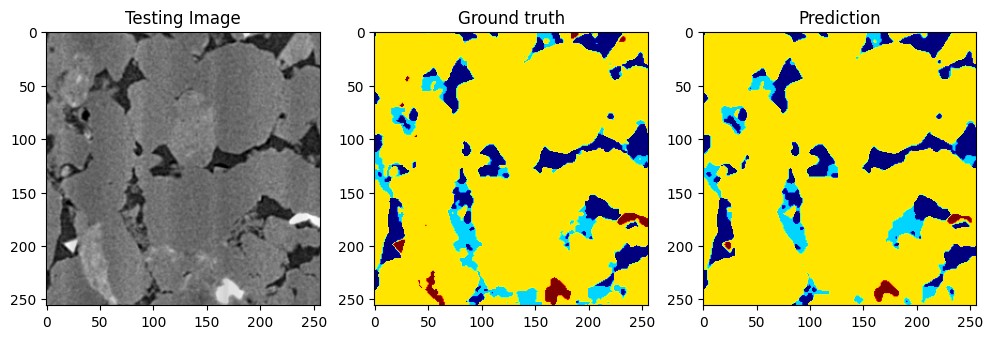

1/1 [==============================] - 0s 25ms/step


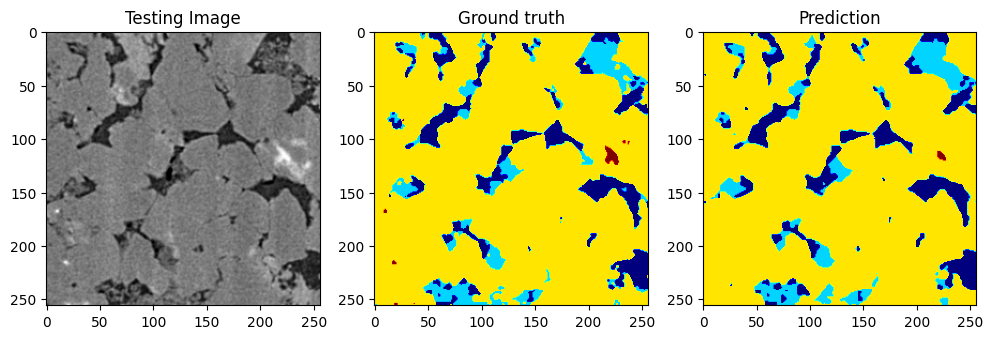

1/1 [==============================] - 0s 35ms/step


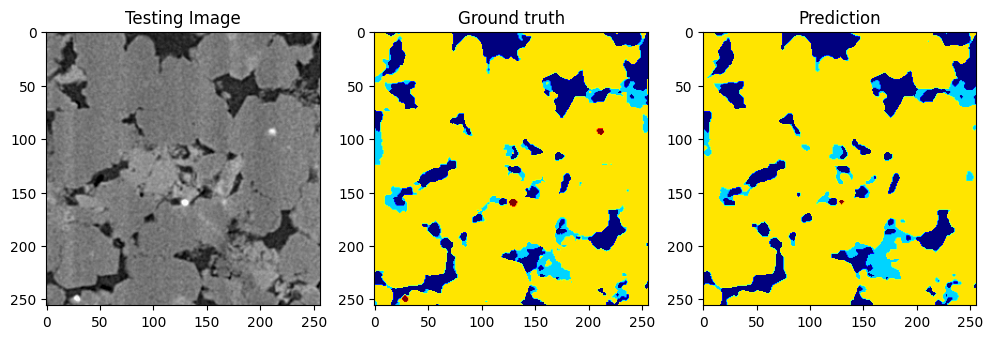

1/1 [==============================] - 0s 30ms/step


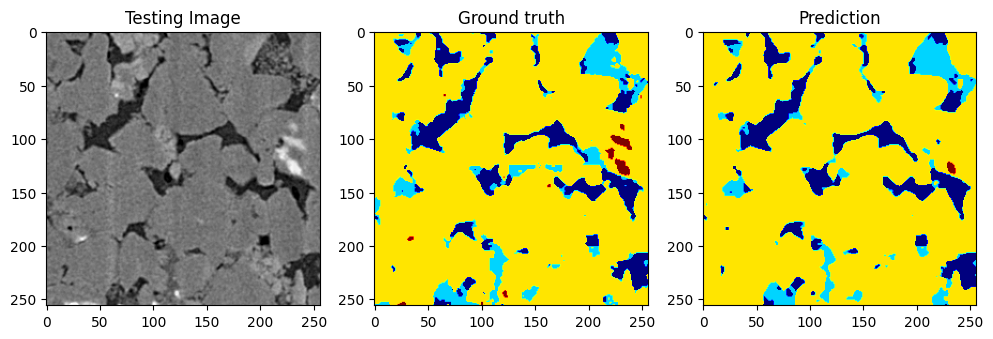

In [141]:
def inference(index, model):
    test_img = np.expand_dims(X_test[index], axis=0) 
    ground_truth = y_test[index]

    prediction = model.predict(test_img)
    predicted_img = np.argmax(prediction, axis=3)[0,:,:]

    plt.figure(figsize=(12, 8))
    plt.subplot(231)
    plt.title('Testing Image')
    plt.imshow(test_img[0,:,:,0], cmap='gray')
    plt.subplot(232)
    plt.title('Ground truth')
    plt.imshow(ground_truth[:,:,0], cmap='jet')
    plt.subplot(233)
    plt.title('Prediction')
    plt.imshow(predicted_img, cmap='jet')
    plt.show()


for i in range(10):
    index = random.randint(0, len(X_test)-1)
    inference(index, model)

### **5. Whole pipeline for prediction**

8/8 [==============================] - 8s 81ms/step


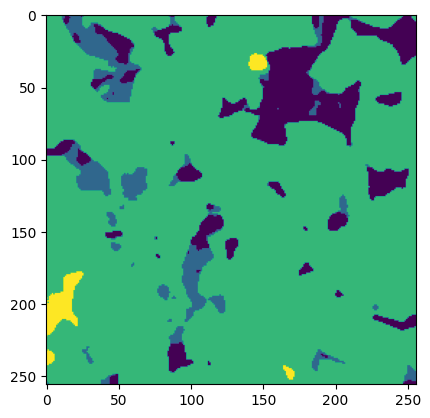

In [2]:
loaded_model = load_model('../models/unet_sandstone_20_ce.hdf5')

# With each type of file --> read into 3D numpy array different (.nii.gz --> SimpleITK, .tiff --> tifffile)
path_volume = '../data/Sandstone/original/data_for_3D_Unet/train_images_256_256_256.tif'
volume = tiff.imread(path_volume)
volume = normalize(np.expand_dims(volume, axis=3), axis=1)  # Normalize + (batch, height, width, channel) --> important
pred = loaded_model.predict(volume)
pred = np.argmax(pred, axis=3)
plt.imshow(pred[250])